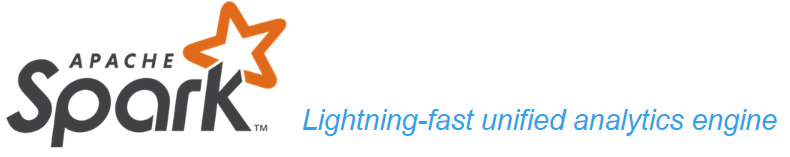

# Regression Models in MLlib
There are several fundamental regression models in MLlib. 

- Linear regression

- Generalized linear regression

- Isotonic regression

- Decision trees

- Random forest

- Gradient-boosted trees

- Survival regression

# Model Scalability
The regression models in MLlib all scale to large datasets. This a simple model scalability scorecard that will help you in choosing the best model for your particular task (if scalability is your core consideration). These will depend on your configuration, machine size, and other factors.
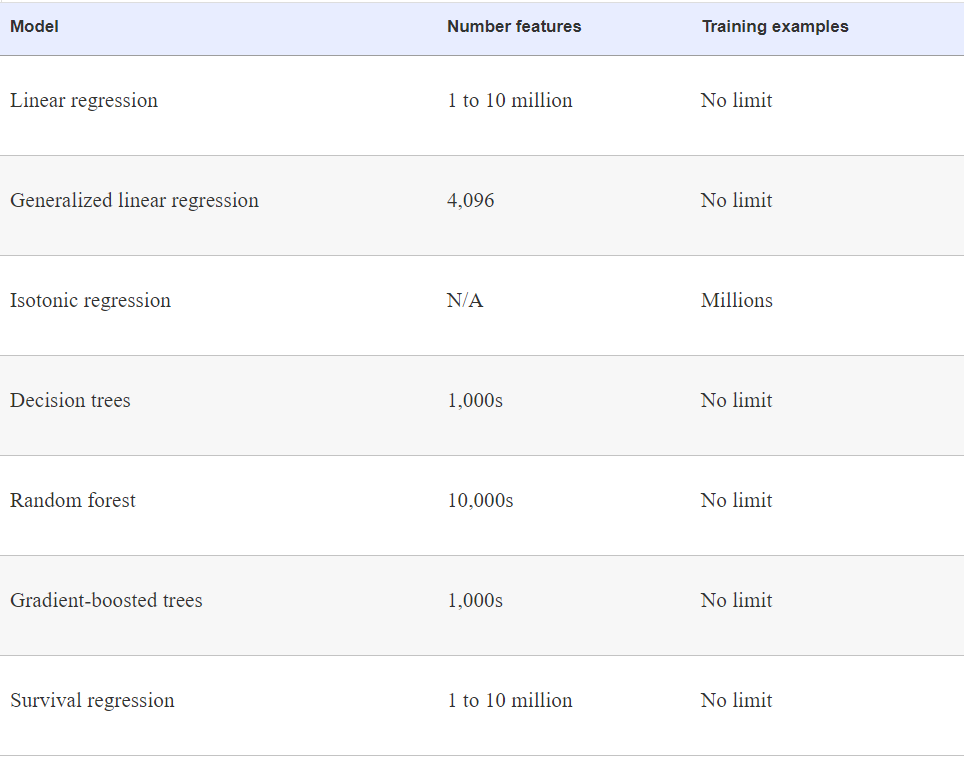

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Linear Regression").getOrCreate()

In [ ]:
# lets read some sample data 
df = spark.read.load("/common_folder/pyspark_data/regression")

In [ ]:
df.show()

# Linear Regression
Linear regression assumes that a linear combination of your input features (the sum of each feature multiplied by a weight) results along with an amount of Gaussian error in the output. 
The learning objective is to minimize the specified loss function, with regularization. This supports two kinds of loss:

1. squaredError (a.k.a squared loss)
2. huber (a hybrid of squared error for relatively small errors and absolute error for relatively large ones, and we estimate the scale parameter from training data)

This supports multiple types of regularization:

- none (a.k.a. ordinary least squares)
- L2 (ridge regression)
- L1 (Lasso)
- L2 + L1 (elastic net)

http://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.regression.LinearRegression

In [ ]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression().setMaxIter(10).setRegParam(0.3).setElasticNetParam(0.8)
lrModel = lr.fit(df)
print(lr.explainParams())


In [ ]:
summary = lrModel.summary
print(summary.totalIterations)
print(summary.objectiveHistory)
print(summary.rootMeanSquaredError)
print(summary.r2)

In [ ]:
from pyspark.ml.regression import GeneralizedLinearRegression
glr = GeneralizedLinearRegression()\
  .setFamily("gaussian")\
  .setLink("identity")\
  .setMaxIter(10)\
  .setRegParam(0.3)\
  .setLinkPredictionCol("linkOut")
print(glr.explainParams())
glrModel = glr.fit(df)

In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor
dtr = DecisionTreeRegressor()
print(dtr.explainParams())
dtrModel = dtr.fit(df)

In [ ]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import GBTRegressor
rf =  RandomForestRegressor()
print(rf.explainParams())
rfModel = rf.fit(df)
gbt = GBTRegressor()
print(gbt.explainParams())
gbtModel = gbt.fit(df)


In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
glr = GeneralizedLinearRegression().setFamily("gaussian").setLink("identity")
pipeline = Pipeline().setStages([glr])
params = ParamGridBuilder().addGrid(glr.regParam, [0, 0.5, 1]).build()
evaluator = RegressionEvaluator()\
  .setMetricName("rmse")\
  .setPredictionCol("prediction")\
  .setLabelCol("label")
cv = CrossValidator()\
  .setEstimator(pipeline)\
  .setEvaluator(evaluator)\
  .setEstimatorParamMaps(params)\
  .setNumFolds(2) # should always be 3 or more but this dataset is small
model = cv.fit(df)

In [ ]:
from pyspark.mllib.evaluation import RegressionMetrics
out = model.transform(df)\
  .select("prediction", "label").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = RegressionMetrics(out)
print("MSE: " + str(metrics.meanSquaredError))
print("RMSE: " + str(metrics.rootMeanSquaredError))
print("R-squared: " + str(metrics.r2))
print("MAE: " + str(metrics.meanAbsoluteError))
print("Explained variance: " + str(metrics.explainedVariance))